# Machine Learning in Network Science
Group Challenge

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers classical unsupervised link prediction techniques.

### 1. Import Packages

In [3]:
from importlib import reload
reload(analyseData)
reload(prepData)
reload(loadData)
reload(modeling)
reload(autoenc)

<module 'util.autoencoder' from 'D:\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T2_Machine Learning in Network Science\\3_challenge\\Network-Science_Challenge\\util\\autoencoder.py'>

In [ ]:
# import own scripts
import util.analyse_Data as analyseData
import util.preprocess_Data as prepData
import util.load_Data as loadData
import util.modeling as modeling
import util.autoencoder as autoenc

In [2]:
# basic stuff
from itertools import product, combinations
from collections import OrderedDict

# parse & handle data
import os
import csv
import numpy as np
import pandas as pd
import networkx as nx # graph data

# modeling
import torch
from torch_geometric.nn import GAE, VGAE
from xgboost import XGBClassifier

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data for Modeling

In [4]:
# might take up to a minute
(G, G_train, node_info,
 train_tf, val_tf, trainval_tf,
 test, test_tf,
 X_train, y_train, X_val, y_val, X_trainval, y_trainval,
 X_test) = loadData.load_transform(testing_ratio = 0.2)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected
Enriching train data...
Enriching validation data...
Enriching test data...


In [5]:
# might take up to a minute
data, _ = autoenc.load(testing_ratio = 0.2)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected


In [6]:
# get node embeddings (IF YOU CHANGE SEED = 42, then you need to train new autoencoder as train-val split is different)

# load best autoencoder
path = os.path.abspath("")+"\\models\\autoencoder.pt"
model = VGAE(autoenc.Encoder(data.x.size()[1], 64, 1.2, 5, 0.2, 0))
model.load_state_dict(torch.load(path))

# get embeddings of nodes
embedding = autoenc.get_embeddings(model, data.x, data.trainval_edges)
node_emb = pd.DataFrame(embedding).rename(columns = {val: f"x{val+1}" for val in range(embedding.shape[1])})

# enrich train
train_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.train_edges)).rename(columns = {0: "sim"})
train_tf = (train_tf
    .assign(sim = train_sim.sim.values)
    .assign(sim_scaled = (train_sim.sim.values - train_sim.sim.values.min()) / (train_sim.sim.values.max() - train_sim.sim.values.min()))
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

# enrich val
val_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.val_edges)).rename(columns = {0: "sim"})
val_tf = (val_tf
    .assign(sim = val_sim.sim.values)
    .assign(sim_scaled = (val_sim.sim.values - val_sim.sim.values.min()) / (val_sim.sim.values.max() - val_sim.sim.values.min()))
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

# enrich test
test_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.trainval_pos_edges, data.test_edges)).rename(columns = {0: "sim"})
test_tf = (test_tf
    .assign(sim = test_sim.sim.values)
    .assign(sim_scaled = (test_sim.sim.values - test_sim.sim.values.min()) / (test_sim.sim.values.max() - test_sim.sim.values.min()))
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

# split
X_train, y_train = loadData.split_frame(train_tf)
X_val, y_val     = loadData.split_frame(val_tf)
X_test           = loadData.split_frame(test_tf)

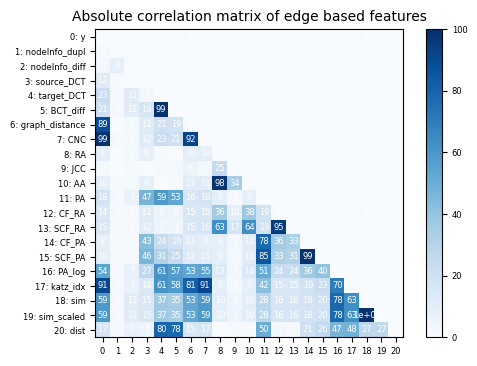

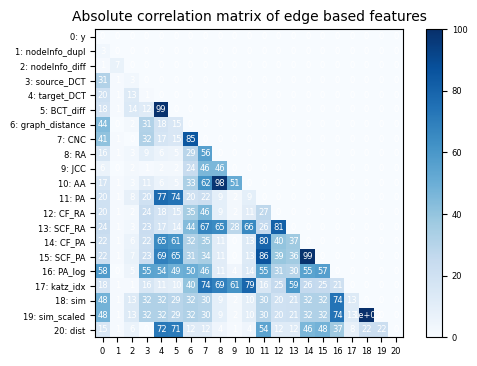

In [7]:
# plot correlation with target (first train, then validation)
for df in [train_tf, val_tf]:
    analyseData.plot_corr_matrix(df.iloc[:, 2:])

### 3. Unsupervised Link Prediction

TODO: try to implement other classical link prediction algos (see lecture 3, Liben-Nowell and Kleinberg Paper in 2003)
- low-rank inner product
- rooted PageRank
- unseen bigrams
- SimRank
- hitting time

regarding dist: cut off should NOT be mean (only for classical link prediction algos!) --> write a function that finds best cutoff point based on validation set for "sim" and "dist" features that come from autoencoder

In [116]:
def compute_score(df, cols, method, thresh):
    # we assume that all metrics get better with increasing values!
    
    df_ = df[list(cols)]
    
    if method == "rank_avg":
        df_ = df_.rank(pct = True).mean(axis = 1)  
    elif method == "avg":
        df_ = df_.mean(axis = 1)
        
    if thresh == "top50%":
        y_hat = (df_ > df_.median()).astype(int)
    elif thresh == "thresh":
        y_hat = (df_ > 0.5).astype(int)
    elif thresh == "rank":
        y_hat = df_.rank(pct = True)
        
    return y_hat

In [117]:
# which cols we want to use for link prediction
res = OrderedDict()

cols = ["katz_idx", "CNC", "RA", "JCC", "AA", "PA", "PA_log"]

methods = ["rank_avg", "avg"]
threshs = ["top50%", "thresh"]

# generate all combinations of columns in cols
sampled_cols = []
for n in range(2, len(cols) + 1):
    sampled_cols += list([c for c in combinations(cols, n)])

for s, m, t in tqdm(product(sampled_cols, methods, threshs)):
    y_train_hat = compute_score(X_train, s, m, t)
    y_val_hat   = compute_score(X_val, s, m, t)
    trn_acc     = accuracy_score(y_train, y_train_hat)
    val_acc     = accuracy_score(y_val, y_val_hat)
    res[(s, m, t)] = {"trn_acc": trn_acc, "val_acc": val_acc}

480it [00:01, 305.08it/s]


In [25]:
ordered_res = (sorted(res.items(), key = lambda kv: kv[1]["val_acc"], reverse = True))

for (col, m, t), val_dict in ordered_res[0:10]:
    print(f"using {col}, {m}, {t}")
    print(f"Train Accuracy {round(val_dict['trn_acc'], 5)}, Val Accuracy {round(val_dict['val_acc'], 5)} \n")

using ('katz_idx', 'RA', 'JCC', 'AA', 'PA_log'), avg, top50%
Train Accuracy 0.74558, Val Accuracy 0.76185 

using ('katz_idx', 'JCC', 'AA', 'PA_log'), avg, top50%
Train Accuracy 0.74606, Val Accuracy 0.76099 

using ('katz_idx', 'RA', 'AA', 'PA_log'), avg, top50%
Train Accuracy 0.73483, Val Accuracy 0.76041 

using ('katz_idx', 'AA', 'PA_log'), avg, top50%
Train Accuracy 0.73495, Val Accuracy 0.75955 

using ('RA', 'JCC', 'AA', 'PA_log'), avg, top50%
Train Accuracy 0.73244, Val Accuracy 0.75869 

using ('JCC', 'AA', 'PA_log'), avg, top50%
Train Accuracy 0.73256, Val Accuracy 0.75783 

using ('RA', 'JCC', 'AA', 'PA_log'), avg, thresh
Train Accuracy 0.72324, Val Accuracy 0.75783 

using ('RA', 'PA'), rank_avg, top50%
Train Accuracy 0.72981, Val Accuracy 0.75754 

using ('RA', 'PA'), rank_avg, thresh
Train Accuracy 0.73172, Val Accuracy 0.75754 

using ('RA', 'PA_log'), rank_avg, top50%
Train Accuracy 0.72981, Val Accuracy 0.75754 



In [118]:
# use best settings
s = ["katz_idx", "RA", "JCC", "AA", "PA_log"]
m = "avg"
t = "top50%"
y_train_hat = compute_score(X_train, s, m, t)
y_val_hat   = compute_score(X_val, s, m, t)
y_test_hat  = compute_score(X_test, s, m, t)

In [120]:
# detailed performance analysis
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Validation performance')
print('-------------------------------------------------------')
print(classification_report(y_val, y_val_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_val, y_val_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_val, y_val_hat))

Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      4198
           1       0.75      0.74      0.74      4174

    accuracy                           0.75      8372
   macro avg       0.75      0.75      0.75      8372
weighted avg       0.75      0.75      0.75      8372

Validation performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.77      0.77      1050
           1       0.77      0.77      0.77      1043

    accuracy                           0.77      2093
   macro avg       0.77      0.77      0.77      2093
weighted avg       0.77      0.77      0.77      2093

Roc_auc score
-------------------------------------------------------
0.774010866091403

Confusion matrix
-------------------------------------------------------
[[812 238]
 [235 808]]


In [121]:
# save test predictions
save_test = modeling.save_test_preds(test, test_tf, y_test_hat)

In [122]:
# look at predicted labels
save_test.value_counts()

Predicted
0            1783
1            1715
dtype: int64

let us now combine our local ensemble model with the embedding similarities from our autoencoder

doesn't really work well...

In [112]:
# now let's try to average these predictions with the results from our autoencoder
s = ["katz_idx", "RA", "JCC", "AA", "PA_log"]
m = "avg"
t = "rank"
y_train_hat = compute_score(X_train, s, m, t)
y_val_hat   = compute_score(X_val, s, m, t)
y_test_hat  = compute_score(X_test, s, m, t)

In [113]:
# take max
y_train_hat = pd.concat([y_train_hat, train_tf.sim.rank(pct = True)], axis = 1).max(axis = 1)
y_train_hat = (y_train_hat > y_train_hat.median()).astype(int)

y_val_hat = pd.concat([y_val_hat, val_tf.sim.rank(pct = True)], axis = 1).max(axis = 1)
y_val_hat = (y_val_hat > y_val_hat.median()).astype(int)

y_test_hat = pd.concat([y_test_hat, test_tf.sim.rank(pct = True)], axis = 1).max(axis = 1)
y_test_hat = (y_test_hat > y_test_hat.median()).astype(int)

In [102]:
# add scaled similarities
alpha = 0.66
beta  = 0.34

y_train_hat = (alpha * y_train_hat + beta * train_tf.sim.rank(pct = True))
y_train_hat = (y_train_hat > y_train_hat.median()).astype(int)

y_val_hat = (alpha * y_val_hat + beta * val_tf.sim.rank(pct = True))
y_val_hat = (y_val_hat > y_val_hat.median()).astype(int)

y_test_hat = (alpha * y_test_hat + beta * test_tf.sim.rank(pct = True))
y_test_hat = (y_test_hat > y_test_hat.median()).astype(int)

In [115]:
# detailed performance analysis
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Validation performance')
print('-------------------------------------------------------')
print(classification_report(y_val, y_val_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_val, y_val_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_val, y_val_hat))

Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.73      0.74      4198
           1       0.73      0.74      0.73      4174

    accuracy                           0.74      8372
   macro avg       0.74      0.74      0.74      8372
weighted avg       0.74      0.74      0.74      8372

Validation performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1050
           1       0.75      0.75      0.75      1043

    accuracy                           0.75      2093
   macro avg       0.75      0.75      0.75      2093
weighted avg       0.75      0.75      0.75      2093

Roc_auc score
-------------------------------------------------------
0.7529881751358262

Confusion matrix
-------------------------------------------------------
[[790 260]
 [257 786]]


In [11]:
from importlib import reload
reload(officialData)

<module 'util.official_Data' from 'D:\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T2_Machine Learning in Network Science\\3_challenge\\Network-Science_Challenge\\util\\official_Data.py'>

In [10]:
import util.official_Data as officialData

In [12]:
enriched_test = officialData.enrich_test()

In [13]:
enriched_test_tf = pd.merge(test_tf, enriched_test, how = "left", on = ["node1", "node2"])
y_col = enriched_test_tf.pop("y")
enriched_test_tf.insert(2, "y", y_col)

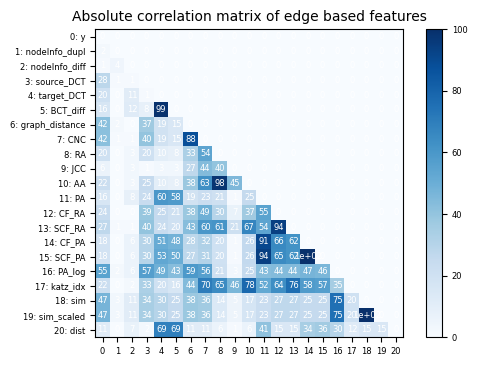

In [14]:
analyseData.plot_corr_matrix(enriched_test_tf.iloc[:, 2:])

In [349]:
y_test_hat.value_counts()

0    1783
1    1698
dtype: int64

In [350]:
enriched_test_tf.y.value_counts()

0    1748
1    1733
Name: y, dtype: int64

In [351]:
accuracy_score(enriched_test_tf.y, y_test_hat)

0.7618500430910657